In [1]:
cd ATML-PA-2/CLIP

/kaggle/working/ATML-PA-2/CLIP


# Task 5: Modality Gap in CLIP


### Importing libraries


Importing the necessary libraries for the task.

In [2]:
import os
import torch
import numpy as np
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn

### Initializing Dataset

Specifying the directories in which the Office-Home data is stored.

In [3]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

The office-home dataset is used to evaluate domain adaptation algorithms, and consists of images from 4 different domains: Artistic images, Clip Art, Product images and Real-World images. For each domain, the dataset contains images of 65 object categories found typically in Office and Home settings https://www.hemanthdv.org/officeHomeDataset.html.

In [4]:
from utils.dataset import OfficeHomeDataset

def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

In [5]:
import random
import PIL 

def display(pil_image):
    plt.imshow(pil_image)
    plt.axis("off")     
    plt.tight_layout()
    plt.show()

In [6]:
domains = ["Art", "Real World", "Product","Clipart"]
dataset = get_domain_ds(domains)
classes = dataset.classes
print("Classes: ", classes)

Classes:  ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calculator', 'Calendar', 'Candles', 'Chair', 'Clipboards', 'Computer', 'Couch', 'Curtains', 'Desk_Lamp', 'Drill', 'Eraser', 'Exit_Sign', 'Fan', 'File_Cabinet', 'Flipflops', 'Flowers', 'Folder', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Kettle', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Notebook', 'Oven', 'Pan', 'Paper_Clip', 'Pen', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Screwdriver', 'Shelf', 'Sink', 'Sneakers', 'Soda', 'Speaker', 'Spoon', 'TV', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'Webcam']


TV


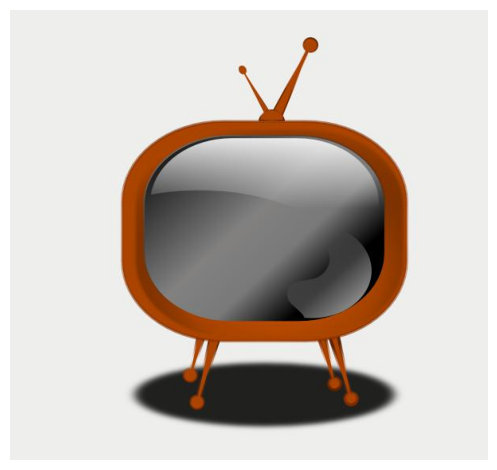

In [7]:
image, label = random.choice(dataset)
print(classes[label])
display(image)

### Downloading and Configuring the CLIP model

Here we import the clip-ViT-B-32 from https://github.com/openai/CLIP and it's corresponding preprocessing transform, 

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [8]:
import clip
import random
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)

### Evaluating Prompting Strategies

Here we test how the zero-shot performance of the model on a few examples and try different prompting strategies. In the first cell, a number of utility functions are defined to help with analysis. 

In [ ]:
from sklearn.metrics import classification_report
import tqdm
from torchmetrics import ConfusionMatrix
import seaborn as sns


def get_image_features(dataset:torch.utils.data.Dataset):
   
    all_features = []
    all_labels = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=os.cpu_count())
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            features = model.encode_image(images)

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu(), torch.cat(all_labels).cpu()

def get_text_features(text: list[str]):
    with torch.no_grad():
        text = clip.tokenize(text)
        return model.encode_text(text).cpu()


def stats(preds, labels):
    confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes))
    print(classification_report(labels, preds, digits=4))
    sns.heatmap(confmat(preds, labels), cmap="Blues")
    plt.show()


def prompt_eval(image_features, text_features, all_labels):
    image_features = image_features/image_features.norm(dim=-1, keepdim=True)
    text_features = text_features/text_features.norm(dim=-1, keepdim=True)

    logits = 100*image_features@text_features.T #we add the multiplicative constant(100) as that is what is done by the implementatation
    preds = logits.argmax(dim=-1).cpu()
    stats(preds, all_labels)


In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
def combine_caches(caches):
    features, labels = zip(*caches)
    return torch.cat(features), torch.cat(labels).cpu()

def eval_cache(cache, prompts):
    image_features, labels = cache
    prompt_eval(image_features, prompts, labels)
    plt.show()

cache_store = {}
for domain in domains:
    cache_store[domain] = get_image_features( get_domain_ds([domain], preprocess))
    print(f"Cached {domain}")


Cached Art
Cached Real World
Cached Product
Cached Clipart


In [12]:
model.to('cpu')

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Evaluating Zero-Shot on domain : Art
              precision    recall  f1-score   support

           0     0.7245    0.9595    0.8256        74
           1     0.8333    0.8537    0.8434        41
           2     0.9091    0.7407    0.8163        27
           3     0.9643    0.6750    0.7941        40
           4     0.9733    0.9733    0.9733        75
           5     0.7723    0.7879    0.7800        99
           6     0.7826    0.4500    0.5714        40
           7     0.9677    0.9091    0.9375        33
           8     0.9500    0.9500    0.9500        20
           9     0.8800    0.8684    0.8742        76
          10     0.8052    0.8986    0.8493        69
          11     0.4286    0.4800    0.4528        25
          12     0.5909    0.5909    0.5909        44
          13     0.9677    0.7500    0.8451        40
          14     0.8462    0.8250    0.8354        40
          15     0.2600    0.5652    0.3562        23
          16     1.0000    0.0667    0.1250 

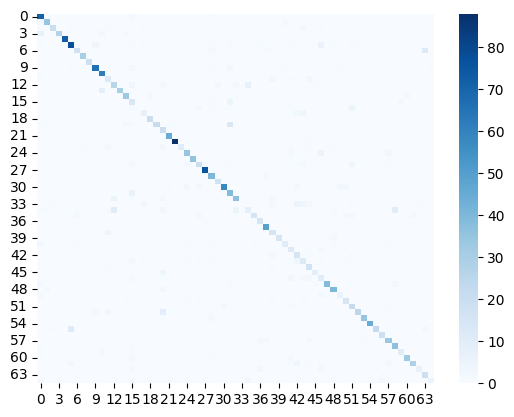

Evaluating Zero-Shot on domain : Real World
              precision    recall  f1-score   support

           0     0.8763    0.9884    0.9290        86
           1     0.9703    0.9899    0.9800        99
           2     0.8889    1.0000    0.9412        64
           3     0.9875    0.9518    0.9693        83
           4     0.9898    0.9798    0.9848        99
           5     0.8289    0.8077    0.8182        78
           6     0.8906    0.7125    0.7917        80
           7     0.9221    0.9726    0.9467        73
           8     0.9306    0.9853    0.9571        68
           9     0.9703    0.9899    0.9800        99
          10     0.8704    0.9792    0.9216        96
          11     0.5641    0.6769    0.6154        65
          12     0.6613    0.6406    0.6508        64
          13     0.9538    0.8158    0.8794        76
          14     0.9481    1.0000    0.9733        73
          15     0.5870    0.8710    0.7013        62
          16     0.7000    0.1373    

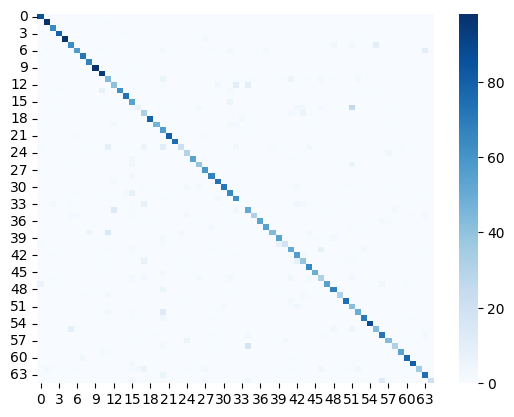

Evaluating Zero-Shot on domain : Product
              precision    recall  f1-score   support

           0     0.8571    0.9873    0.9176        79
           1     0.9231    0.9697    0.9458        99
           2     0.7632    0.9355    0.8406        62
           3     0.8600    1.0000    0.9247        43
           4     0.9778    1.0000    0.9888        44
           5     0.9167    0.7097    0.8000        62
           6     0.9697    0.6809    0.8000        47
           7     0.8617    1.0000    0.9257        81
           8     0.9733    0.9012    0.9359        81
           9     0.9643    0.9643    0.9643        56
          10     0.9263    0.8889    0.9072        99
          11     0.4130    0.5846    0.4841        65
          12     0.9730    0.3750    0.5414        96
          13     0.9753    0.8977    0.9349        88
          14     0.9861    0.9467    0.9660        75
          15     0.5970    0.9639    0.7373        83
          16     0.8889    0.1194    0.2

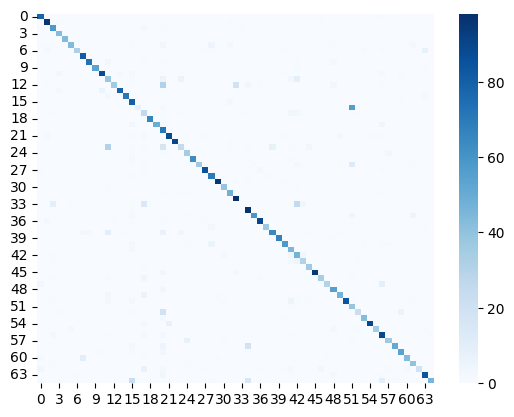

Evaluating Zero-Shot on domain : Clipart
              precision    recall  f1-score   support

           0     0.4615    0.9000    0.6102        60
           1     0.9787    0.8214    0.8932        56
           2     0.7143    0.5469    0.6195        64
           3     0.9398    0.7959    0.8619        98
           4     0.9787    0.9293    0.9534        99
           5     0.6458    0.6263    0.6359        99
           6     0.6190    0.5342    0.5735        73
           7     0.5172    0.9783    0.6767        46
           8     0.9595    0.9103    0.9342        78
           9     0.9516    0.5960    0.7329        99
          10     0.8469    0.8384    0.8426        99
          11     0.2963    0.4000    0.3404        40
          12     0.3810    0.3232    0.3497        99
          13     0.8478    0.6094    0.7091        64
          14     0.9667    0.6905    0.8056        42
          15     0.2286    0.1951    0.2105        41
          16     0.6667    0.0833    0.1

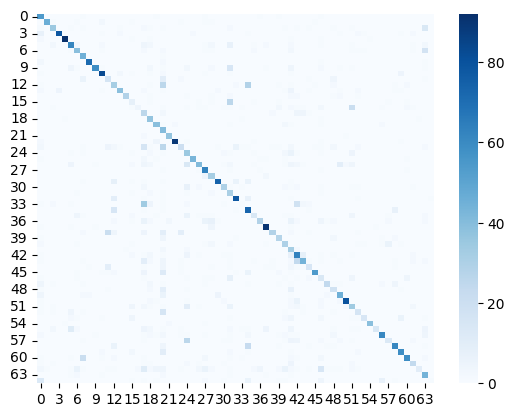

In [13]:
prompts = get_text_features(classes)
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain}")
    eval_cache(cache, prompts)

Evaluating Zero-Shot on domain : Art (with modified prompts)
              precision    recall  f1-score   support

           0     0.9221    0.9595    0.9404        74
           1     0.8889    0.7805    0.8312        41
           2     0.9500    0.7037    0.8085        27
           3     0.8500    0.8500    0.8500        40
           4     0.9867    0.9867    0.9867        75
           5     0.8955    0.6061    0.7229        99
           6     0.9286    0.3250    0.4815        40
           7     1.0000    0.8788    0.9355        33
           8     1.0000    0.9000    0.9474        20
           9     0.8684    0.8684    0.8684        76
          10     0.8243    0.8841    0.8531        69
          11     0.5000    0.4400    0.4681        25
          12     0.6429    0.4091    0.5000        44
          13     0.9697    0.8000    0.8767        40
          14     0.9167    0.8250    0.8684        40
          15     0.2083    0.4348    0.2817        23
          16     0.5

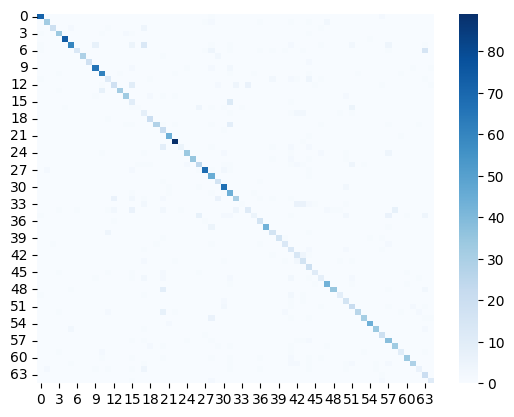

Evaluating Zero-Shot on domain : Real World (with modified prompts)
              precision    recall  f1-score   support

           0     0.9043    0.9884    0.9444        86
           1     0.9794    0.9596    0.9694        99
           2     0.9275    1.0000    0.9624        64
           3     0.9529    0.9759    0.9643        83
           4     0.9900    1.0000    0.9950        99
           5     0.8732    0.7949    0.8322        78
           6     0.8382    0.7125    0.7703        80
           7     0.9861    0.9726    0.9793        73
           8     0.9710    0.9853    0.9781        68
           9     0.9800    0.9899    0.9849        99
          10     0.9126    0.9792    0.9447        96
          11     0.6471    0.5077    0.5690        65
          12     0.5645    0.5469    0.5556        64
          13     0.9710    0.8816    0.9241        76
          14     0.9865    1.0000    0.9932        73
          15     0.6066    0.5968    0.6016        62
          16 

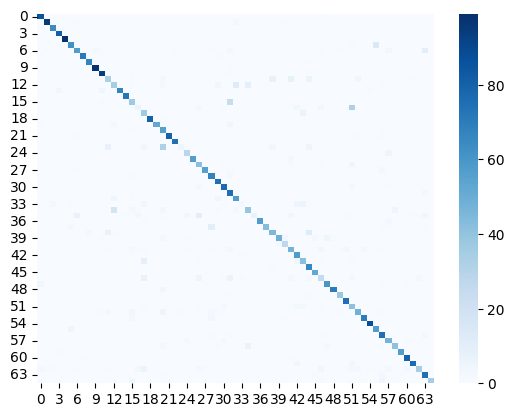

Evaluating Zero-Shot on domain : Product (with modified prompts)
              precision    recall  f1-score   support

           0     0.9390    0.9747    0.9565        79
           1     0.9895    0.9495    0.9691        99
           2     0.7671    0.9032    0.8296        62
           3     0.8600    1.0000    0.9247        43
           4     0.9565    1.0000    0.9778        44
           5     0.8696    0.6452    0.7407        62
           6     0.7333    0.7021    0.7174        47
           7     0.9310    1.0000    0.9643        81
           8     0.9605    0.9012    0.9299        81
           9     0.9818    0.9643    0.9730        56
          10     0.8725    0.8990    0.8856        99
          11     0.4394    0.4462    0.4427        65
          12     0.5906    0.7812    0.6726        96
          13     0.9870    0.8636    0.9212        88
          14     1.0000    0.9467    0.9726        75
          15     0.7604    0.8795    0.8156        83
          16    

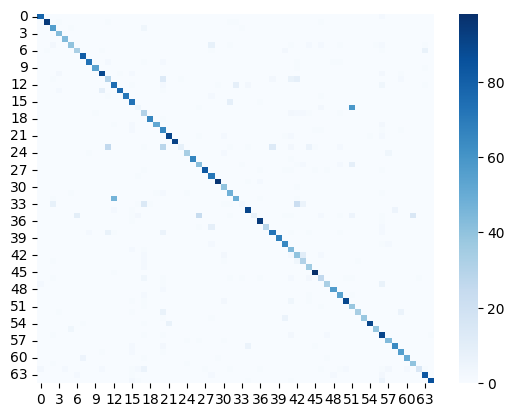

Evaluating Zero-Shot on domain : Clipart (with modified prompts)
              precision    recall  f1-score   support

           0     0.6310    0.8833    0.7361        60
           1     1.0000    0.7500    0.8571        56
           2     0.8000    0.5625    0.6606        64
           3     0.9146    0.7653    0.8333        98
           4     1.0000    0.9192    0.9579        99
           5     0.8113    0.4343    0.5658        99
           6     0.7143    0.2055    0.3191        73
           7     0.7167    0.9348    0.8113        46
           8     0.9583    0.8846    0.9200        78
           9     0.9667    0.5859    0.7296        99
          10     0.8830    0.8384    0.8601        99
          11     0.6154    0.2000    0.3019        40
          12     0.3046    0.4646    0.3680        99
          13     0.8605    0.5781    0.6916        64
          14     1.0000    0.5952    0.7463        42
          15     0.1000    0.0488    0.0656        41
          16    

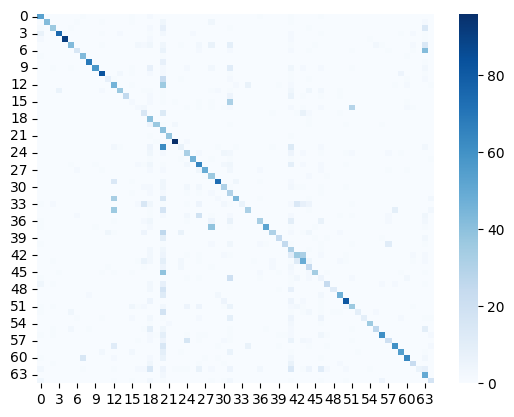

In [14]:
prompts = get_text_features(["look at that "+ cls for cls in classes])
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain} (with modified prompts)")
    eval_cache(cache, prompts)

Evaluating Zero-Shot on domain : Art (with domain-specific prompts)
              precision    recall  f1-score   support

           0     0.9688    0.8378    0.8986        74
           1     0.7500    0.8780    0.8090        41
           2     0.7857    0.8148    0.8000        27
           3     0.9697    0.8000    0.8767        40
           4     0.9487    0.9867    0.9673        75
           5     0.7250    0.8788    0.7945        99
           6     0.7000    0.7000    0.7000        40
           7     0.8857    0.9394    0.9118        33
           8     0.7917    0.9500    0.8636        20
           9     0.7955    0.9211    0.8537        76
          10     0.8676    0.8551    0.8613        69
          11     0.2830    0.6000    0.3846        25
          12     0.3780    0.7045    0.4921        44
          13     0.8974    0.8750    0.8861        40
          14     0.7778    0.8750    0.8235        40
          15     0.3333    0.6522    0.4412        23
          16 

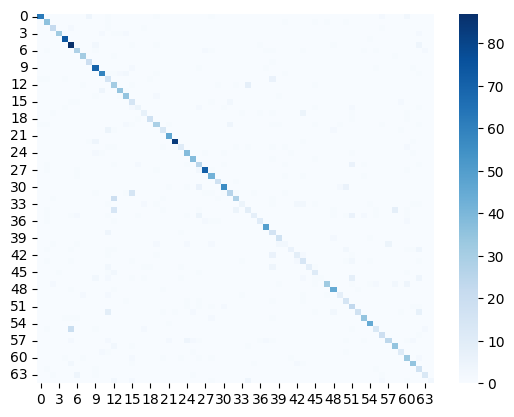

Evaluating Zero-Shot on domain : Real World (with domain-specific prompts)
              precision    recall  f1-score   support

           0     0.8600    1.0000    0.9247        86
           1     0.9706    1.0000    0.9851        99
           2     0.9538    0.9688    0.9612        64
           3     0.9630    0.9398    0.9512        83
           4     0.9899    0.9899    0.9899        99
           5     0.6696    0.9615    0.7895        78
           6     0.7971    0.6875    0.7383        80
           7     0.9859    0.9589    0.9722        73
           8     0.9855    1.0000    0.9927        68
           9     0.9802    1.0000    0.9900        99
          10     0.9126    0.9792    0.9447        96
          11     0.6818    0.6923    0.6870        65
          12     0.5846    0.5938    0.5891        64
          13     0.9583    0.9079    0.9324        76
          14     0.8902    1.0000    0.9419        73
          15     0.6618    0.7258    0.6923        62
      

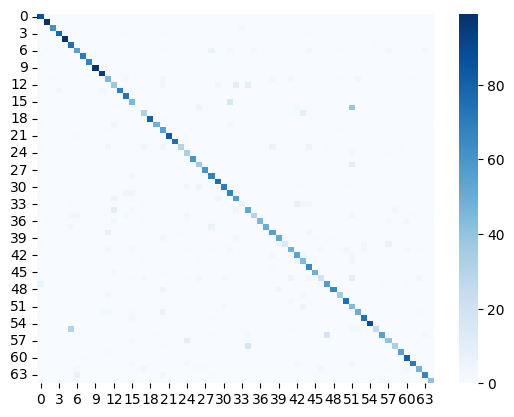

Evaluating Zero-Shot on domain : Product (with domain-specific prompts)
              precision    recall  f1-score   support

           0     0.9630    0.9873    0.9750        79
           1     0.9600    0.9697    0.9648        99
           2     0.8308    0.8710    0.8504        62
           3     0.8600    1.0000    0.9247        43
           4     0.8980    1.0000    0.9462        44
           5     0.9231    0.7742    0.8421        62
           6     0.8400    0.8936    0.8660        47
           7     0.9878    1.0000    0.9939        81
           8     0.9861    0.8765    0.9281        81
           9     0.9811    0.9286    0.9541        56
          10     0.9518    0.7980    0.8681        99
          11     0.4615    0.4615    0.4615        65
          12     0.7812    0.7812    0.7812        96
          13     0.8737    0.9432    0.9071        88
          14     0.8929    1.0000    0.9434        75
          15     0.9868    0.9036    0.9434        83
         

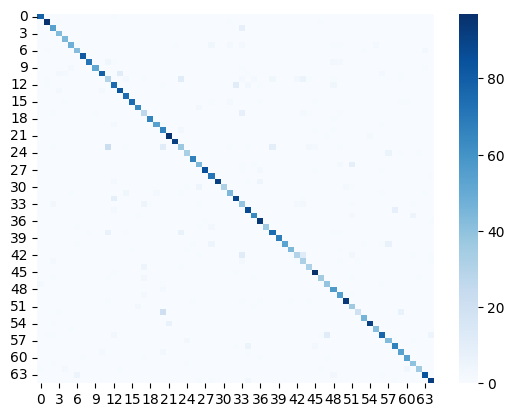

Evaluating Zero-Shot on domain : Clipart (with domain-specific prompts)
              precision    recall  f1-score   support

           0     0.8154    0.8833    0.8480        60
           1     0.9057    0.8571    0.8807        56
           2     0.6066    0.5781    0.5920        64
           3     0.8710    0.8265    0.8482        98
           4     0.9787    0.9293    0.9534        99
           5     0.6824    0.5859    0.6304        99
           6     0.5417    0.7123    0.6154        73
           7     0.5287    1.0000    0.6917        46
           8     0.9714    0.8718    0.9189        78
           9     0.8902    0.7374    0.8066        99
          10     0.9529    0.8182    0.8804        99
          11     0.3846    0.5000    0.4348        40
          12     0.2632    0.3030    0.2817        99
          13     0.8261    0.5938    0.6909        64
          14     0.7805    0.7619    0.7711        42
          15     0.4211    0.1951    0.2667        41
         

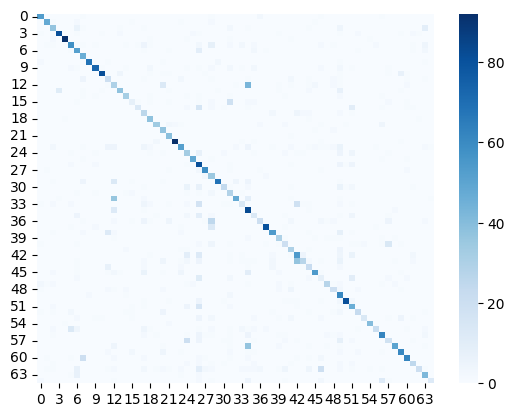

In [15]:
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain} (with domain-specific prompts)")
    prompts = get_text_features([f"{domain} photo of "+ cls for cls in classes])
    eval_cache(cache, prompts)

### Evaluating CLIP accuracy on Image Features

In [16]:
from sklearn.linear_model import LogisticRegression

torch.manual_seed(100)

classifiers = {}
for domain in domains:
    print(f"Probing on domain : {domain}")
    features, labels = cache_store[domain]
    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    classifier.fit(features, labels)
    classifiers[domain] = classifier 
  
   

Probing on domain : Art


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


Probing on domain : Real World


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s finished


Probing on domain : Product


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s finished


Probing on domain : Clipart


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished


In [ ]:
domains

Product -> Real World
              precision    recall  f1-score   support

           0     0.9140    0.9884    0.9497        86
           1     0.9897    0.9697    0.9796        99
           2     0.9815    0.8281    0.8983        64
           3     0.9589    0.8434    0.8974        83
           4     0.9895    0.9495    0.9691        99
           5     0.7460    0.6026    0.6667        78
           6     0.7750    0.7750    0.7750        80
           7     0.8987    0.9726    0.9342        73
           8     0.9067    1.0000    0.9510        68
           9     0.9286    0.9192    0.9239        99
          10     0.8364    0.9583    0.8932        96
          11     0.6000    0.3231    0.4200        65
          12     0.3171    0.6094    0.4171        64
          13     0.9153    0.7105    0.8000        76
          14     0.7742    0.9863    0.8675        73
          15     0.6941    0.9516    0.8027        62
          16     0.9697    0.6275    0.7619        51
     

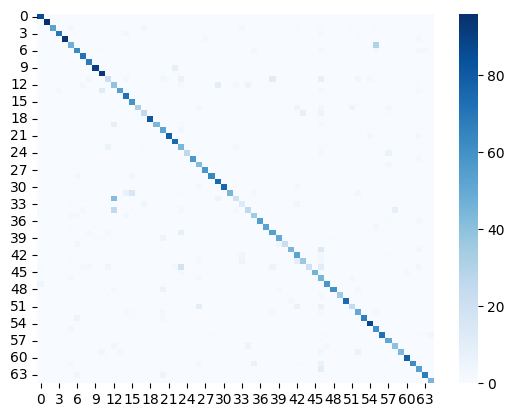

Art -> Clipart
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        60
           1     0.9730    0.6429    0.7742        56
           2     0.6066    0.5781    0.5920        64
           3     0.9508    0.5918    0.7296        98
           4     0.9293    0.9293    0.9293        99
           5     0.9688    0.3131    0.4733        99
           6     0.4113    0.6986    0.5178        73
           7     0.5641    0.9565    0.7097        46
           8     1.0000    0.8590    0.9241        78
           9     0.9429    0.6667    0.7811        99
          10     0.9853    0.6768    0.8024        99
          11     0.1976    0.8250    0.3188        40
          12     0.3760    0.4747    0.4196        99
          13     0.7800    0.6094    0.6842        64
          14     0.7692    0.7143    0.7407        42
          15     0.2500    0.3659    0.2970        41
          16     0.5294    0.5625    0.5455        48
          17

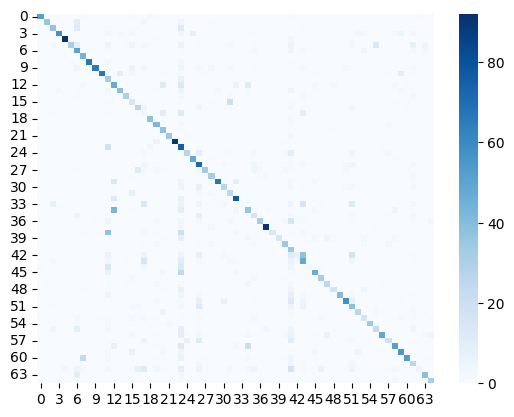

Product -> Art
              precision    recall  f1-score   support

           0     0.9167    0.8919    0.9041        74
           1     0.9667    0.7073    0.8169        41
           2     1.0000    0.4815    0.6500        27
           3     0.8929    0.6250    0.7353        40
           4     1.0000    0.8400    0.9130        75
           5     0.5789    0.5556    0.5670        99
           6     0.5714    0.3000    0.3934        40
           7     0.9062    0.8788    0.8923        33
           8     0.6452    1.0000    0.7843        20
           9     0.9429    0.8684    0.9041        76
          10     0.6463    0.7681    0.7020        69
          11     0.6250    0.4000    0.4878        25
          12     0.2195    0.2045    0.2118        44
          13     0.8889    0.4000    0.5517        40
          14     0.5185    0.7000    0.5957        40
          15     0.2449    0.5217    0.3333        23
          16     0.7143    0.3333    0.4545        15
          17

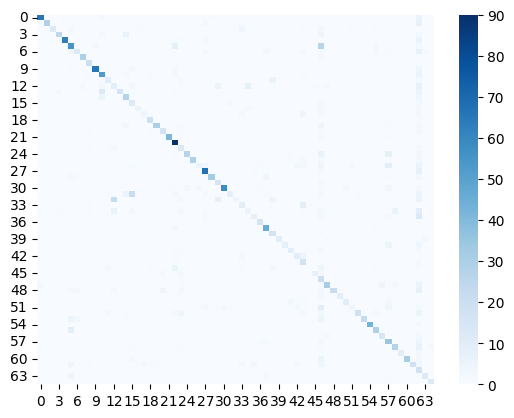

Art -> Real World
              precision    recall  f1-score   support

           0     0.9767    0.9767    0.9767        86
           1     0.9406    0.9596    0.9500        99
           2     0.7381    0.9688    0.8378        64
           3     0.7426    0.9036    0.8152        83
           4     0.9252    1.0000    0.9612        99
           5     0.8704    0.6026    0.7121        78
           6     0.6900    0.8625    0.7667        80
           7     0.8182    0.9863    0.8944        73
           8     0.9714    1.0000    0.9855        68
           9     0.9700    0.9798    0.9749        99
          10     0.9175    0.9271    0.9223        96
          11     0.6122    0.4615    0.5263        65
          12     0.5455    0.6562    0.5957        64
          13     0.9385    0.8026    0.8652        76
          14     0.9524    0.5479    0.6957        73
          15     0.7941    0.4355    0.5625        62
          16     0.8974    0.6863    0.7778        51
         

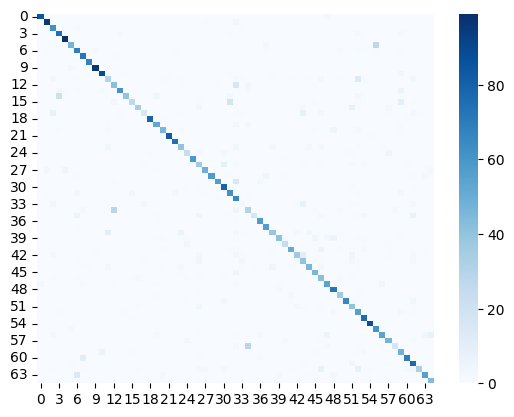

Real World -> Clipart
              precision    recall  f1-score   support

           0     0.9434    0.8333    0.8850        60
           1     1.0000    0.7321    0.8454        56
           2     0.9286    0.4062    0.5652        64
           3     0.9701    0.6633    0.7879        98
           4     0.9785    0.9192    0.9479        99
           5     0.8421    0.4848    0.6154        99
           6     0.5867    0.6027    0.5946        73
           7     0.7167    0.9348    0.8113        46
           8     0.9437    0.8590    0.8993        78
           9     0.9661    0.5758    0.7215        99
          10     0.9467    0.7172    0.8161        99
          11     0.4444    0.1000    0.1633        40
          12     0.3148    0.5152    0.3908        99
          13     0.7288    0.6719    0.6992        64
          14     0.9630    0.6190    0.7536        42
          15     0.4375    0.1707    0.2456        41
          16     0.7826    0.3750    0.5070        48
     

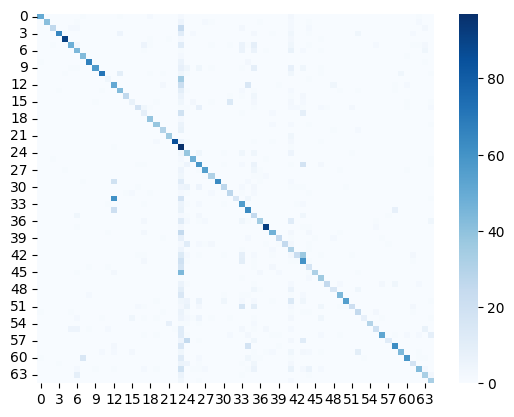

Product -> Clipart
              precision    recall  f1-score   support

           0     0.8571    0.8000    0.8276        60
           1     1.0000    0.6429    0.7826        56
           2     1.0000    0.4062    0.5778        64
           3     0.9792    0.4796    0.6438        98
           4     1.0000    0.9192    0.9579        99
           5     0.3834    0.7475    0.5068        99
           6     0.6393    0.5342    0.5821        73
           7     0.8400    0.9130    0.8750        46
           8     0.6754    0.9872    0.8021        78
           9     1.0000    0.4242    0.5957        99
          10     0.7822    0.7980    0.7900        99
          11     0.2101    0.6250    0.3145        40
          12     0.3939    0.5253    0.4502        99
          13     0.8857    0.4844    0.6263        64
          14     0.7500    0.5714    0.6486        42
          15     0.3111    0.3415    0.3256        41
          16     0.9167    0.4583    0.6111        48
        

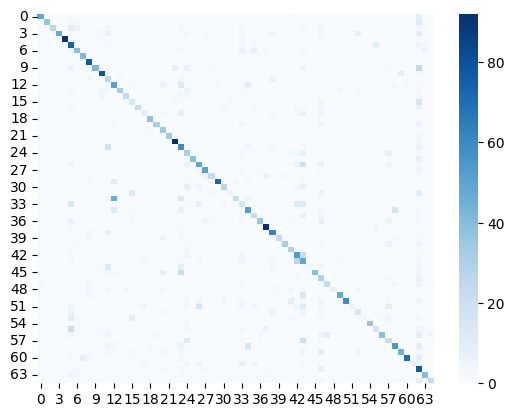

In [17]:
pairs = [
    # Low-shift
    ("Product", "Real World"),
    ("Art", "Clipart"),

    # Medium-shift
    ("Product", "Art"),
    ("Art", "Real World"),

    # High-shift
    ("Real World", "Clipart"),
    ("Product", "Clipart")
]

for source, target in pairs:
    print(f"{source} -> {target}")
    classifier = classifiers[source]
    target_features, target_labels = cache_store[target]
    predictions = classifier.predict(target_features)
  
    stats(torch.Tensor(predictions), target_labels)
    


### Co-op  and Co-Co-op

In [18]:
clip.available_models()

class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  
        x = self.ln_final(x).type(self.dtype)

        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

class PromptLearner(nn.Module):
    def __init__(self, classes, clip_model, csc, n_ctx):
        super().__init__()
        self.n_cls = len(classes)   
        self.n_ctx =  n_ctx  
        self.ctx_dim = clip_model.ln_final.weight.shape[0]
        dtype = clip_model.dtype

        if csc:
            print("Initializing class-specific contexts")
            ctx_vectors = torch.empty(self.n_cls, self.n_ctx, self.ctx_dim).type(dtype)
        else:
            print("Initializing a generic context")
            ctx_vectors = torch.empty(self.n_ctx, self.ctx_dim).type(dtype)
        
        nn.init.normal_(ctx_vectors, std=0.02) #the coop implementation intializes vectors randomly
        prompt_prefix = " ".join(["X"] * self.n_ctx)  #place holder for learnable tokens  
        self.ctx = nn.Parameter(ctx_vectors) 

        classnames = [name.replace("_", " ") for name in classes]
        prompts = [prompt_prefix + " "+cls + "." for cls in classnames]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        self.register_buffer("tokenized_prompts", tokenized_prompts)
        self.register_buffer("prefix", embedding[:, :1, :])  #[SOS] token
        self.register_buffer("suffix", embedding[:, 1 + self.n_ctx :, :])  #class token + [EOS] token

        
    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1) #expands the ctx to the appropriate view, when dealing with unified context.
            #(self.n_cls, n_ctx, ctx_dim)
     
        prompts = torch.cat(
            [self.prefix,ctx,self.suffix,],
            dim=1,
        )
        return prompts
        
class CustomCLIP(nn.Module):
    def __init__(self, classnames, clip_model, csc, n_ctx):
        super().__init__()
        self.prompt_learner = PromptLearner(classnames, clip_model, csc, n_ctx)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image_features):
        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logits = 100 * image_features @ text_features.t()

        return logits
    

            

In [35]:
clip.available_models()

class MetaNet(nn.Module):
    def __init__(self, in_features, dtype):
        super().__init__()
          
        self.layer1 = nn.Linear(in_features, 32, dtype=dtype)
        self.relu = nn.ReLU(inplace=True)
        self.layer2 = nn.Linear(32, in_features, dtype=dtype)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

class PromptLearnerCoCoOp(nn.Module):
    def __init__(self, classes, clip_model, n_ctx):
        super().__init__()
        self.n_cls = len(classes)   
        self.n_ctx =  n_ctx  
        self.ctx_dim = clip_model.ln_final.weight.shape[0]
        dtype = clip_model.dtype

        ctx_vectors = torch.empty(self.n_ctx, self.ctx_dim).type(dtype)
        nn.init.normal_(ctx_vectors, std=0.02) #the coop implementation intializes vectors randomly
        prompt_prefix = " ".join(["X"] * self.n_ctx)  #place holder for learnable tokens  
        self.ctx = nn.Parameter(ctx_vectors) 

        self.metanet = MetaNet(clip_model.ln_final.weight.shape[0], dtype)

        classnames = [name.replace("_", " ") for name in classes]
        prompts = [prompt_prefix + " "+cls + "." for cls in classnames]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).to(dtype)

        self.register_buffer("tokenized_prompts", tokenized_prompts)
        self.register_buffer("prefix", embedding[:, :1, :])  #[SOS] token
        self.register_buffer("suffix", embedding[:, 1 + self.n_ctx :, :])  #class token + [EOS] token
        

    def forward(self, image_features):
        ctx = self.ctx                     # (n_ctx, ctx_dim)
        bias = self.metanet(image_features)  # (batch, ctx_dim)
        bias = bias.unsqueeze(1)           # (batch, 1, ctx_dim)
        ctx = ctx.unsqueeze(0)             # (1, n_ctx, ctx_dim)
        ctx_shifted = ctx + bias           # (batch, n_ctx, ctx_dim)
        
        prompts = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = torch.cat([self.prefix,ctx_i,self.suffix,], dim=1,)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)
        
        return prompts
    
        
class CustomCLIPCoCoOp(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx):
        super().__init__()
        self.prompt_learner = PromptLearnerCoCoOp(classnames, clip_model, n_ctx)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image_features):
        
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        prompts = self.prompt_learner(image_features) #we normalize first before pushing true metanet for stability    
        tokenized_prompts = self.tokenized_prompts
    

        logits = []
        for prompt, feats in zip(prompts, image_features):
            text_features = self.text_encoder(prompt, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            logit = 100 * feats @ text_features.t()
            logits.append(logit)
        logits = torch.stack(logits)

        return logits

In [20]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [21]:

def train(cache, classnames, config, device):
    lr = config.get('lr', 1e-5)
    shot = config.get('shot', 1)
    epochs = config.get('epochs', 5)
    csc = config.get('csc', False)
    n_ctx = config.get('n_ctx', 16)
    
    freq_count = {cls:0 for cls in classnames}
    feats = []
    labels = []
    
    for feat, label in zip(*cache):
        cls = classnames[label.item()]
        if freq_count[cls]<shot:
            feats.append(feat)
            labels.append(label)
            freq_count[cls] += 1
    
    
    X = torch.stack(feats).float()
    Y = torch.stack(labels)

    model = CustomCLIP(classnames, clip_model, csc, n_ctx)
    loss_fn = nn.CrossEntropyLoss()
    dtype = model.dtype

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model.to(device)
    model.train()
    X , Y = X.to(device).type(dtype), Y.to(device).long()
    

    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, Y)
        loss.backward()
        optimizer.step()
    
    return model



def train_cocoop(cache, classnames, config, device):
    lr = config.get('lr', 1e-5)
    shot = config.get('shot', 1)
    epochs = config.get('epochs', 5)
    n_ctx = config.get('n_ctx', 16)
    
    freq_count = {cls:0 for cls in classnames}
    feats = []
    labels = []
    
    for feat, label in zip(*cache):
        cls = classnames[label.item()]
        if freq_count[cls]<shot:
            feats.append(feat)
            labels.append(label)
            freq_count[cls] += 1
    
    
    X = torch.stack(feats).float()
    Y = torch.stack(labels)

    model = CustomCLIPCoCoOp(classnames, clip_model, n_ctx)
    loss_fn = nn.CrossEntropyLoss()
    dtype = model.dtype

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model.to(device)
    model.train()
    X , Y = X.to(device).type(dtype), Y.to(device).long()
    
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, Y)
        loss.backward()
        optimizer.step()
    
    return model

In [22]:
def eval_coop(config, pairs):
    domain_models = {}
    for domain_name, cache in cache_store.items():
        # print(f"Training on domain: {domain_name}\n")

        trained_model = train(     
            cache=cache,        
            classnames=classes,
            config=config,
            device=device
        )
        domain_models[domain_name] = trained_model

    for source, target in pairs:
        print(f"{source} -> {target}")
        feats, labels = cache_store[target]
        domain_model = domain_models[source]
        
        domain_model.eval()

        with torch.no_grad():
            domain_model.to(device)
            feats = feats.to(device)

            logits = domain_models[source](feats).cpu()
            preds = logits.argmax(dim=-1)
            
            stats(preds, labels)

def eval_cocoop(config, pairs):
    domain_models = {}
    for domain_name, cache in cache_store.items():
        # print(f"Training on domain: {domain_name}\n")

        trained_model = train_cocoop(     
            cache=cache,        
            classnames=classes,
            config=config,
            device=device
        )
        domain_models[domain_name] = trained_model

    for source, target in pairs:
        print(f"{source} -> {target}")
        feats, labels = cache_store[target]
        domain_model = domain_models[source]
        
        domain_model.eval()

        with torch.no_grad():
            domain_model.to(device)
            feats = feats.to(device)

            logits = domain_models[source](feats).cpu()
            preds = logits.argmax(dim=-1)
            
            stats(preds, labels)

Initializing a generic context
Initializing a generic context
Initializing a generic context
Initializing a generic context
Product -> Real World
              precision    recall  f1-score   support

           0     0.9438    0.9767    0.9600        86
           1     1.0000    0.9899    0.9949        99
           2     0.9815    0.8281    0.8983        64
           3     0.9487    0.8916    0.9193        83
           4     0.9900    1.0000    0.9950        99
           5     0.9423    0.6282    0.7538        78
           6     0.8769    0.7125    0.7862        80
           7     1.0000    0.9589    0.9790        73
           8     0.9315    1.0000    0.9645        68
           9     0.9706    1.0000    0.9851        99
          10     0.9388    0.9583    0.9485        96
          11     0.6667    0.5231    0.5862        65
          12     0.7931    0.3594    0.4946        64
          13     0.9577    0.8947    0.9252        76
          14     0.7157    1.0000    0.8343

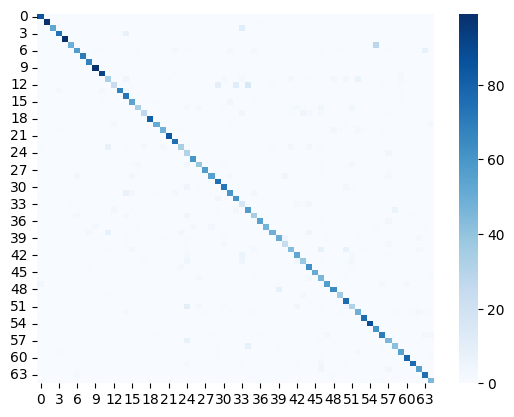

Art -> Clipart
              precision    recall  f1-score   support

           0     0.9615    0.8333    0.8929        60
           1     0.9200    0.8214    0.8679        56
           2     0.7872    0.5781    0.6667        64
           3     0.8571    0.7959    0.8254        98
           4     0.9892    0.9293    0.9583        99
           5     0.6566    0.6566    0.6566        99
           6     0.7568    0.3836    0.5091        73
           7     0.8000    0.9565    0.8713        46
           8     0.9583    0.8846    0.9200        78
           9     0.9194    0.5758    0.7081        99
          10     0.9222    0.8384    0.8783        99
          11     0.3929    0.5500    0.4583        40
          12     0.5556    0.2020    0.2963        99
          13     0.7123    0.8125    0.7591        64
          14     0.5763    0.8095    0.6733        42
          15     0.3250    0.3171    0.3210        41
          16     0.7105    0.5625    0.6279        48
          17

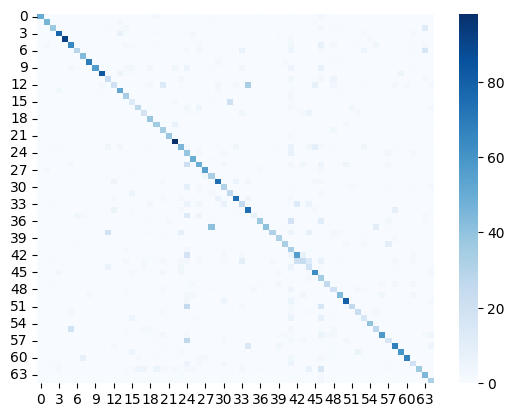

Product -> Art
              precision    recall  f1-score   support

           0     1.0000    0.9054    0.9504        74
           1     0.8409    0.9024    0.8706        41
           2     1.0000    0.5556    0.7143        27
           3     0.8929    0.6250    0.7353        40
           4     0.9737    0.9867    0.9801        75
           5     0.7969    0.5152    0.6258        99
           6     0.7273    0.6000    0.6575        40
           7     1.0000    0.9394    0.9688        33
           8     0.8696    1.0000    0.9302        20
           9     0.9444    0.8947    0.9189        76
          10     0.8644    0.7391    0.7969        69
          11     0.4848    0.6400    0.5517        25
          12     0.6154    0.1818    0.2807        44
          13     0.7955    0.8750    0.8333        40
          14     0.5522    0.9250    0.6916        40
          15     0.3929    0.4783    0.4314        23
          16     0.3200    0.5333    0.4000        15
          17

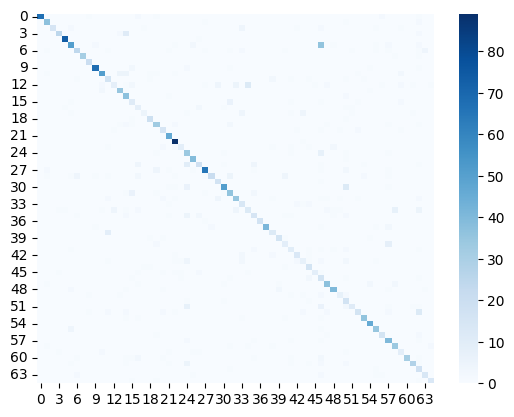

Art -> Real World
              precision    recall  f1-score   support

           0     0.9655    0.9767    0.9711        86
           1     0.9899    0.9899    0.9899        99
           2     0.9831    0.9062    0.9431        64
           3     0.9494    0.9036    0.9259        83
           4     0.9802    1.0000    0.9900        99
           5     0.9138    0.6795    0.7794        78
           6     0.9091    0.6250    0.7407        80
           7     0.9857    0.9452    0.9650        73
           8     0.9855    1.0000    0.9927        68
           9     0.9802    1.0000    0.9900        99
          10     0.9307    0.9792    0.9543        96
          11     0.6905    0.4462    0.5421        65
          12     0.6667    0.3438    0.4536        64
          13     0.9452    0.9079    0.9262        76
          14     0.7449    1.0000    0.8538        73
          15     0.7297    0.8710    0.7941        62
          16     0.9143    0.6275    0.7442        51
         

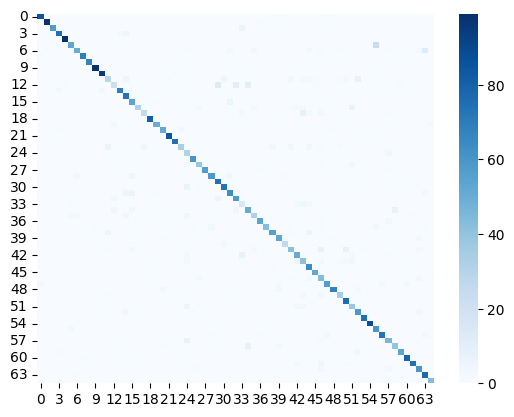

Real World -> Clipart
              precision    recall  f1-score   support

           0     0.9444    0.8500    0.8947        60
           1     0.9583    0.8214    0.8846        56
           2     1.0000    0.4375    0.6087        64
           3     0.9241    0.7449    0.8249        98
           4     0.9892    0.9293    0.9583        99
           5     0.7222    0.6566    0.6878        99
           6     0.7576    0.3425    0.4717        73
           7     0.7719    0.9565    0.8544        46
           8     0.9605    0.9359    0.9481        78
           9     0.9455    0.5253    0.6753        99
          10     0.9506    0.7778    0.8556        99
          11     0.2921    0.6500    0.4031        40
          12     0.4688    0.1515    0.2290        99
          13     0.7324    0.8125    0.7704        64
          14     0.5312    0.8095    0.6415        42
          15     0.3659    0.3659    0.3659        41
          16     0.8049    0.6875    0.7416        48
     

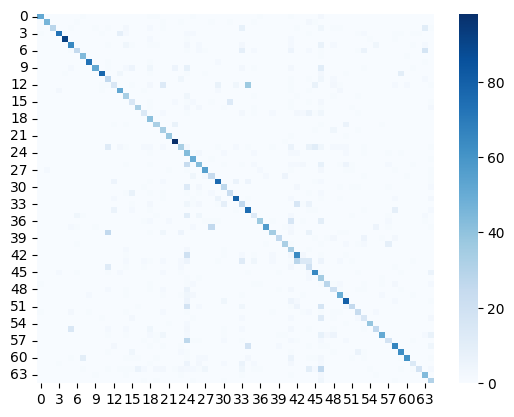

Product -> Clipart
              precision    recall  f1-score   support

           0     0.9107    0.8500    0.8793        60
           1     0.8868    0.8393    0.8624        56
           2     0.7609    0.5469    0.6364        64
           3     0.8902    0.7449    0.8111        98
           4     0.9892    0.9293    0.9583        99
           5     0.6900    0.6970    0.6935        99
           6     0.6275    0.4384    0.5161        73
           7     0.7857    0.9565    0.8627        46
           8     0.9610    0.9487    0.9548        78
           9     0.8889    0.5657    0.6914        99
          10     0.9432    0.8384    0.8877        99
          11     0.2828    0.7000    0.4029        40
          12     0.5862    0.1717    0.2656        99
          13     0.6667    0.8125    0.7324        64
          14     0.6364    0.8333    0.7216        42
          15     0.4483    0.3171    0.3714        41
          16     0.6800    0.7083    0.6939        48
        

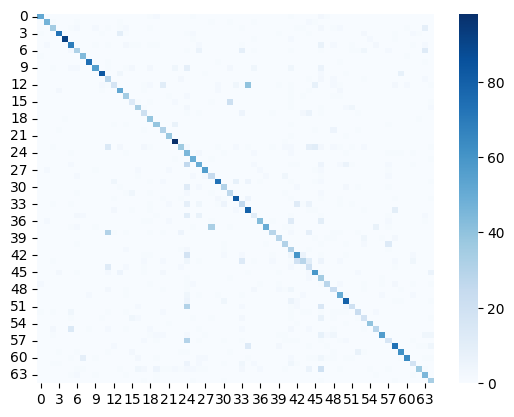

In [23]:
config = {'epochs': 3, 
          'lr':1e-3, 
          'csc':False,
          'n_ctx':16,
          'shot':1,
          }
eval_coop(config, pairs)

Initializing a generic context
Initializing a generic context
Initializing a generic context
Initializing a generic context
Product -> Real World
              precision    recall  f1-score   support

           0     0.9540    0.9651    0.9595        86
           1     0.9800    0.9899    0.9849        99
           2     0.9846    1.0000    0.9922        64
           3     0.9625    0.9277    0.9448        83
           4     0.9802    1.0000    0.9900        99
           5     0.9444    0.6538    0.7727        78
           6     0.8395    0.8500    0.8447        80
           7     1.0000    0.9589    0.9790        73
           8     0.8500    1.0000    0.9189        68
           9     0.9167    1.0000    0.9565        99
          10     0.9479    0.9479    0.9479        96
          11     0.8043    0.5692    0.6667        65
          12     0.6600    0.5156    0.5789        64
          13     0.9333    0.9211    0.9272        76
          14     0.9241    1.0000    0.9605

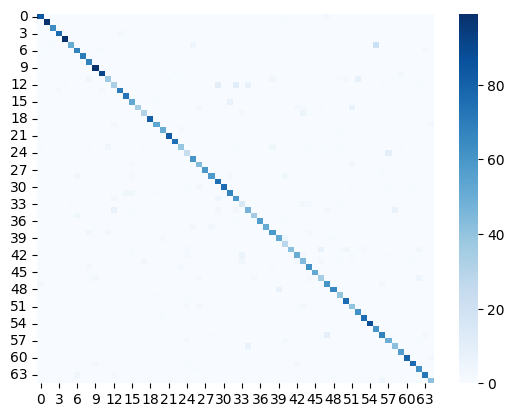

Art -> Clipart
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        60
           1     0.8868    0.8393    0.8624        56
           2     0.5974    0.7188    0.6525        64
           3     0.9487    0.7551    0.8409        98
           4     0.9892    0.9293    0.9583        99
           5     0.6837    0.6768    0.6802        99
           6     0.7414    0.5890    0.6565        73
           7     0.7963    0.9348    0.8600        46
           8     0.9359    0.9359    0.9359        78
           9     0.8000    0.7273    0.7619        99
          10     0.9412    0.8081    0.8696        99
          11     0.4462    0.7250    0.5524        40
          12     0.4286    0.3030    0.3550        99
          13     0.6933    0.8125    0.7482        64
          14     0.8261    0.9048    0.8636        42
          15     0.4062    0.3171    0.3562        41
          16     0.7037    0.7917    0.7451        48
          17

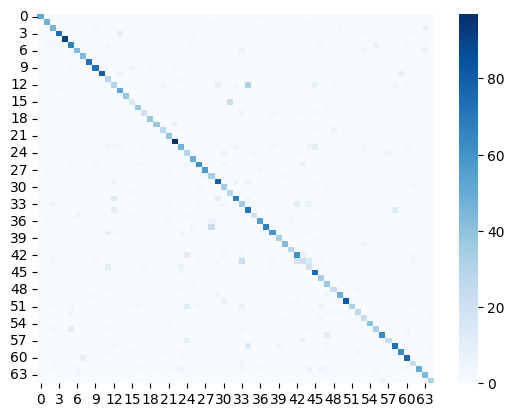

Product -> Art
              precision    recall  f1-score   support

           0     0.9714    0.9189    0.9444        74
           1     0.9459    0.8537    0.8974        41
           2     1.0000    0.7407    0.8511        27
           3     0.9143    0.8000    0.8533        40
           4     0.9615    1.0000    0.9804        75
           5     0.8312    0.6465    0.7273        99
           6     0.7273    0.8000    0.7619        40
           7     1.0000    0.9091    0.9524        33
           8     0.7692    1.0000    0.8696        20
           9     0.9211    0.9211    0.9211        76
          10     0.8806    0.8551    0.8676        69
          11     0.6154    0.6400    0.6275        25
          12     0.5200    0.2955    0.3768        44
          13     0.8043    0.9250    0.8605        40
          14     0.8333    1.0000    0.9091        40
          15     0.4815    0.5652    0.5200        23
          16     0.4762    0.6667    0.5556        15
          17

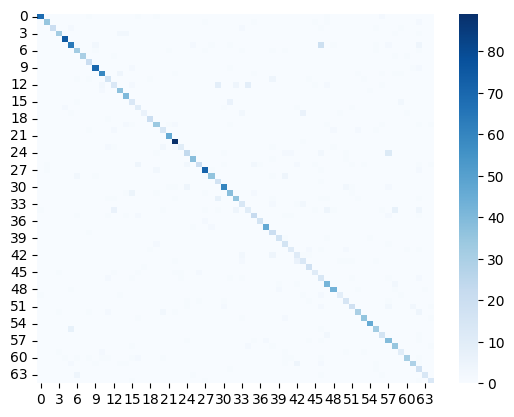

Art -> Real World
              precision    recall  f1-score   support

           0     0.9762    0.9535    0.9647        86
           1     0.9899    0.9899    0.9899        99
           2     0.9552    1.0000    0.9771        64
           3     0.9750    0.9398    0.9571        83
           4     0.9899    0.9899    0.9899        99
           5     0.9455    0.6667    0.7820        78
           6     0.8533    0.8000    0.8258        80
           7     0.9859    0.9589    0.9722        73
           8     0.9067    1.0000    0.9510        68
           9     0.9429    1.0000    0.9706        99
          10     0.9574    0.9375    0.9474        96
          11     0.8000    0.6154    0.6957        65
          12     0.6667    0.5312    0.5913        64
          13     0.9324    0.9079    0.9200        76
          14     0.9012    1.0000    0.9481        73
          15     0.8154    0.8548    0.8346        62
          16     0.9211    0.6863    0.7865        51
         

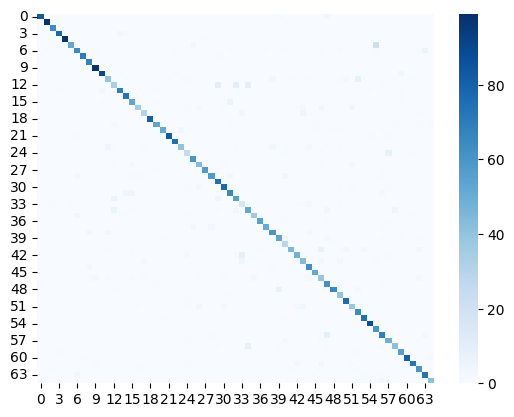

Real World -> Clipart
              precision    recall  f1-score   support

           0     0.8966    0.8667    0.8814        60
           1     0.8545    0.8393    0.8468        56
           2     0.5844    0.7031    0.6383        64
           3     0.9610    0.7551    0.8457        98
           4     0.9892    0.9293    0.9583        99
           5     0.6697    0.7374    0.7019        99
           6     0.7541    0.6301    0.6866        73
           7     0.7736    0.8913    0.8283        46
           8     0.9367    0.9487    0.9427        78
           9     0.7957    0.7475    0.7708        99
          10     0.9302    0.8081    0.8649        99
          11     0.4167    0.7500    0.5357        40
          12     0.6538    0.1717    0.2720        99
          13     0.7083    0.7969    0.7500        64
          14     0.8261    0.9048    0.8636        42
          15     0.4688    0.3659    0.4110        41
          16     0.7692    0.8333    0.8000        48
     

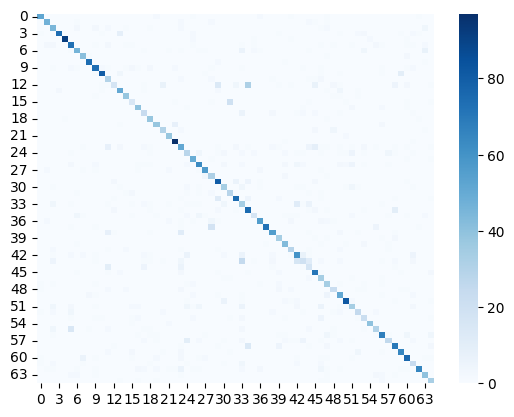

Product -> Clipart
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        60
           1     0.8421    0.8571    0.8496        56
           2     0.5625    0.7031    0.6250        64
           3     0.9615    0.7653    0.8523        98
           4     0.9684    0.9293    0.9485        99
           5     0.6970    0.6970    0.6970        99
           6     0.6974    0.7260    0.7114        73
           7     0.7069    0.8913    0.7885        46
           8     0.8750    0.9872    0.9277        78
           9     0.7400    0.7475    0.7437        99
          10     0.9310    0.8182    0.8710        99
          11     0.4265    0.7250    0.5370        40
          12     0.5167    0.3131    0.3899        99
          13     0.7083    0.7969    0.7500        64
          14     0.8222    0.8810    0.8506        42
          15     0.5000    0.3415    0.4058        41
          16     0.7826    0.7500    0.7660        48
        

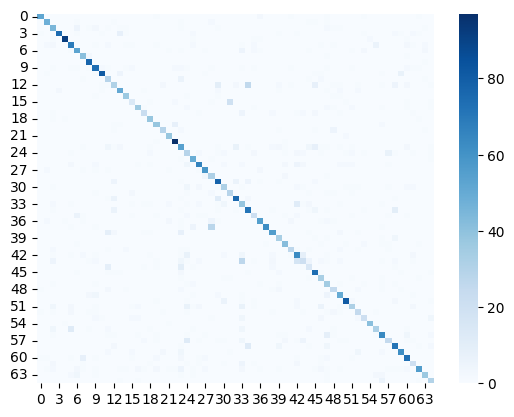

In [24]:
config = {'epochs': 3, 
          'lr':1e-3, 
          'csc':False,
          'n_ctx':16,
          'shot':4,
          }
eval_coop(config, pairs)

Initializing class-specific contexts
Initializing class-specific contexts
Initializing class-specific contexts
Initializing class-specific contexts
Product -> Real World
              precision    recall  f1-score   support

           0     0.9438    0.9767    0.9600        86
           1     0.9899    0.9899    0.9899        99
           2     0.9538    0.9688    0.9612        64
           3     0.9643    0.9759    0.9701        83
           4     0.9899    0.9899    0.9899        99
           5     0.9483    0.7051    0.8088        78
           6     0.8630    0.7875    0.8235        80
           7     0.9726    0.9726    0.9726        73
           8     0.9714    1.0000    0.9855        68
           9     0.9519    1.0000    0.9754        99
          10     0.9278    0.9375    0.9326        96
          11     0.7963    0.6615    0.7227        65
          12     0.6538    0.5312    0.5862        64
          13     0.9444    0.8947    0.9189        76
          14     0.

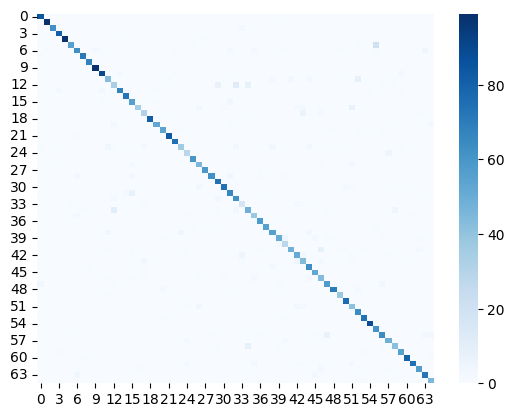

Art -> Clipart
              precision    recall  f1-score   support

           0     0.9464    0.8833    0.9138        60
           1     0.8889    0.8571    0.8727        56
           2     0.7302    0.7188    0.7244        64
           3     0.9412    0.8163    0.8743        98
           4     0.9892    0.9293    0.9583        99
           5     0.7789    0.7475    0.7629        99
           6     0.7377    0.6164    0.6716        73
           7     0.8000    0.9565    0.8713        46
           8     0.9487    0.9487    0.9487        78
           9     0.9167    0.6667    0.7719        99
          10     0.9425    0.8283    0.8817        99
          11     0.5000    0.6500    0.5652        40
          12     0.3592    0.3737    0.3663        99
          13     0.8125    0.8125    0.8125        64
          14     0.8182    0.8571    0.8372        42
          15     0.2911    0.5610    0.3833        41
          16     0.8261    0.7917    0.8085        48
          17

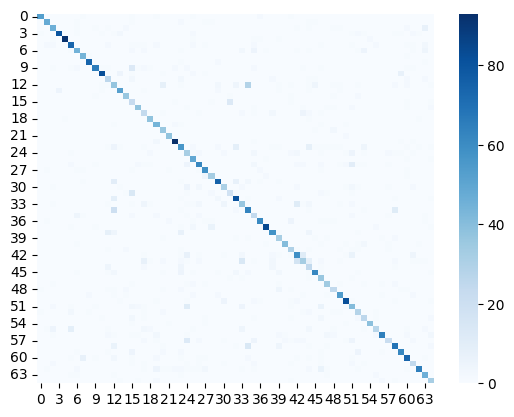

Product -> Art
              precision    recall  f1-score   support

           0     0.9859    0.9459    0.9655        74
           1     0.8333    0.8537    0.8434        41
           2     0.8333    0.7407    0.7843        27
           3     0.9714    0.8500    0.9067        40
           4     0.9610    0.9867    0.9737        75
           5     0.8556    0.7778    0.8148        99
           6     0.8108    0.7500    0.7792        40
           7     1.0000    0.9394    0.9688        33
           8     1.0000    1.0000    1.0000        20
           9     0.9324    0.9079    0.9200        76
          10     0.9077    0.8551    0.8806        69
          11     0.6667    0.8000    0.7273        25
          12     0.6279    0.6136    0.6207        44
          13     0.8085    0.9500    0.8736        40
          14     0.8478    0.9750    0.9070        40
          15     0.4054    0.6522    0.5000        23
          16     0.6111    0.7333    0.6667        15
          17

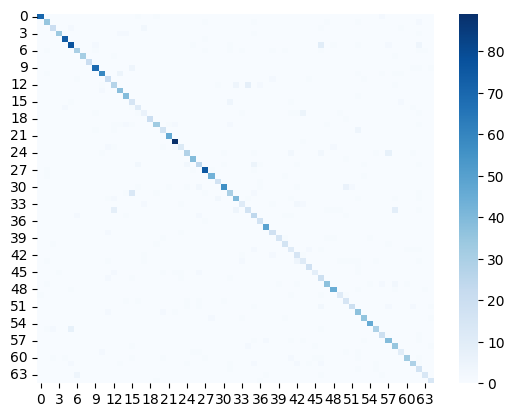

Art -> Real World
              precision    recall  f1-score   support

           0     0.9438    0.9767    0.9600        86
           1     0.9798    0.9798    0.9798        99
           2     0.9844    0.9844    0.9844        64
           3     0.9419    0.9759    0.9586        83
           4     0.9899    0.9899    0.9899        99
           5     0.9167    0.7051    0.7971        78
           6     0.8767    0.8000    0.8366        80
           7     0.9726    0.9726    0.9726        73
           8     0.9577    1.0000    0.9784        68
           9     0.9802    1.0000    0.9900        99
          10     0.9490    0.9688    0.9588        96
          11     0.8269    0.6615    0.7350        65
          12     0.6346    0.5156    0.5690        64
          13     0.9583    0.9079    0.9324        76
          14     0.9605    1.0000    0.9799        73
          15     0.7467    0.9032    0.8175        62
          16     0.9714    0.6667    0.7907        51
         

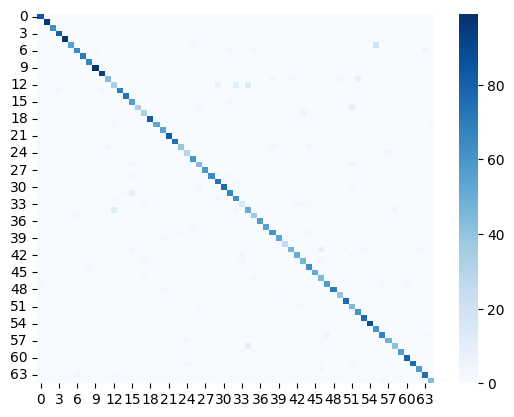

Real World -> Clipart
              precision    recall  f1-score   support

           0     0.9636    0.8833    0.9217        60
           1     0.9796    0.8571    0.9143        56
           2     0.7333    0.6875    0.7097        64
           3     0.9744    0.7755    0.8636        98
           4     0.9894    0.9394    0.9637        99
           5     0.7600    0.7677    0.7638        99
           6     0.6974    0.7260    0.7114        73
           7     0.8000    0.9565    0.8713        46
           8     0.9481    0.9359    0.9419        78
           9     0.8605    0.7475    0.8000        99
          10     0.9222    0.8384    0.8783        99
          11     0.5000    0.7000    0.5833        40
          12     0.3652    0.4242    0.3925        99
          13     0.7681    0.8281    0.7970        64
          14     0.7500    0.8571    0.8000        42
          15     0.4634    0.4634    0.4634        41
          16     0.7551    0.7708    0.7629        48
     

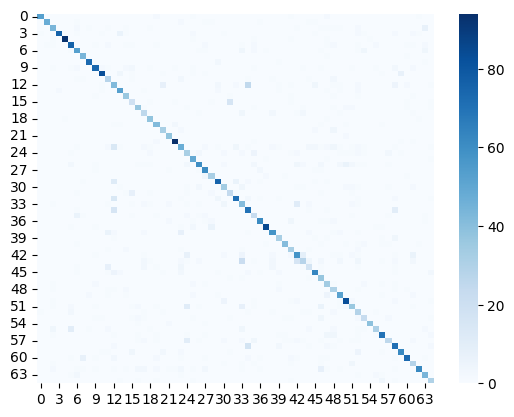

Product -> Clipart
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        60
           1     0.9434    0.8929    0.9174        56
           2     0.6216    0.7188    0.6667        64
           3     0.9294    0.8061    0.8634        98
           4     0.9787    0.9293    0.9534        99
           5     0.6218    0.7475    0.6789        99
           6     0.7581    0.6438    0.6963        73
           7     0.7097    0.9565    0.8148        46
           8     0.9012    0.9359    0.9182        78
           9     0.7660    0.7273    0.7461        99
          10     0.9000    0.8182    0.8571        99
          11     0.4909    0.6750    0.5684        40
          12     0.4141    0.5354    0.4670        99
          13     0.7534    0.8594    0.8029        64
          14     0.8182    0.8571    0.8372        42
          15     0.4000    0.4390    0.4186        41
          16     0.8049    0.6875    0.7416        48
        

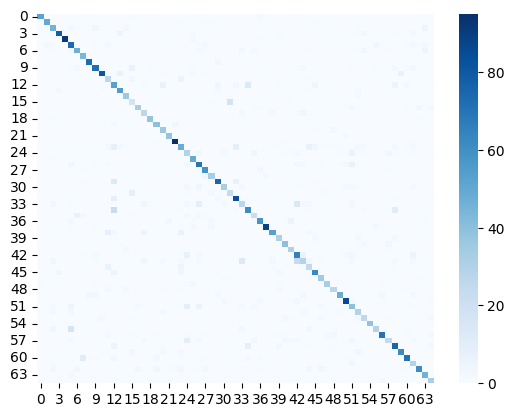

In [26]:
config = {'epochs': 3, 
          'lr':1e-3, 
          'csc':True,
          'n_ctx':16,
          'shot':32,
          }
eval_coop(config, pairs)

In [36]:
config = {'epochs': 3, 
          'lr':1e-3, 
          'csc':False,
          'n_ctx':16,
          'shot':1,
          }
eval_cocoop(config, pairs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 29.12 MiB is free. Process 48170 has 15.86 GiB memory in use. Of the allocated memory 15.38 GiB is allocated by PyTorch, and 180.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Exploring the Modality Gap


In this section, we explore the modality gap in multi-modal embedding space of clip. We use 5000 examples from and umap for dimensionality reduction. 


In [ ]:
import umap

epsilon = 0.01
def reduce_features(features:torch.tensor):
    clone = features.clone().detach()
    reduced = torch.tensor(umap.UMAP(n_neighbors=30, n_components=2).fit_transform(clone))
    return reduced

def visualize_map(image_features: torch.tensor, text_features: torch.tensor):

    X, Y  = image_features[:, 0], image_features[:, 1]
    plt.scatter(X, Y, c="r",label="Image features",
        alpha=0.6, edgecolors='k', marker="o")
    
    X, Y  = text_features[:, 0], text_features[:, 1]
    plt.scatter(X, Y, c="b",  label="Text features",
        alpha=0.6,  edgecolors='k', marker="^")

    plt.title("CLIP Feature Space (2D)")
    plt.xlabel("Feature dimension 1")
    plt.ylabel("Feature dimension 2")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

def plot_embedding_space(image_features: torch.tensor, text_features: torch.tensor):
    N = len(image_features)
    embeddings = torch.cat([image_features, text_features], dim=0)
    reduced = reduce_features(embeddings)
    visualize_map(reduced[:N], reduced[N:])



In [ ]:
class_embeddings = get_text_features(classes)

In [ ]:
plot_embedding_space(features, class_embeddings)

As can be see above, the modality gap between image and text features is larger than one would have expected. Moreover all label embeddings are concentrated in a single region. Below we test text embeddings extracted from pinterest, similar to the data the model was trained on. We also try to visualize the multi-model embedding space after normalizing features.

In [ ]:
combined = torch.concat([features, class_embeddings], dim=0)
mean = combined.mean()
std = combined.std()
normalized = (combined-mean)/std
plot_embedding_space(normalized[:len(features)], normalized[len(features):])


In [ ]:
import requests 
from bs4 import BeautifulSoup

url = 'https://www.pinterest.com/ideas/'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, features="html.parser")

tags = soup.find_all('a')
captions = [tag.text for tag in tags]

In [ ]:
text_features = get_text_features(captions)
plot_embedding_space(features, text_features)

### Bridging the Modality Gap

In this section we try to align that modalities in multi-modal embedding space using the orthogonal procrustes transform.

In [ ]:
from scipy.linalg import orthogonal_procrustes

text_embeddings = torch.stack([class_embeddings[i] for i in labels.tolist()], dim=0)
R, _ = orthogonal_procrustes(features, text_embeddings)
rotated_embeddings = features@R

In [ ]:
plot_embedding_space(rotated_embeddings, class_embeddings)

In [ ]:
eval(rotated_embeddings, class_embeddings, labels)